In [ ]:
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat
from docling.pipeline.standard_pdf_pipeline import StandardPdfPipeline
from docling.datamodel.pipeline_options import (
    PdfPipelineOptions
)
from docling_core.types.doc import (
    TextItem,
    PictureItem,
    TableItem
)
from pathlib import Path
import os
from docling_core.transforms.serializer.markdown import MarkdownDocSerializer

from typing import Literal
from pydantic import BaseModel, Field
from enum import Enum
from tqdm import tqdm
import math

model_path = "models/docling-project/models"
# filepath = "data/pdf/LatestAIAdvancements.pdf"
filepath = "PENDING"

print(os.path.exists(filepath))

class ExtractedType(str, Enum):
    TABLE = "table"
    FIGURE = "figure"
    TEXT = "text"


class Language(str, Enum):
    FRENCH = "french"
    ENGLISH = "english"


class Coordinates(BaseModel):
    x1: int = Field(default=0, ge=0)
    y1: int = Field(default=0, ge=0)
    x2: int = Field(default=0, ge=0)
    y2: int = Field(default=0, ge=0)

class Extracted(BaseModel):
    extracted_type: ExtractedType = Field(ExtractedType.TEXT)
    page_no: int | None = None
    path: os.PathLike | None = None
    coordinates: Coordinates | None = None
    data: bytes | str | None = None
    data_type: Literal["image/png", "image/jpg", "application/pdf", "text"] = Field("text")

class ExtractionResults(BaseModel):
    texts: list[Extracted]
    tables: list[Extracted]
    figures: list[Extracted]


True


In [8]:
converter = DocumentConverter(
    format_options={

        InputFormat.PDF: PdfFormatOption(
            # pipeline_cls=VlmPipeline,
            pipline_cls=StandardPdfPipeline,
            pipeline_options=PdfPipelineOptions(artifacts_path=Path(model_path, "model_artifacts/complete"),    # Model Path!
                                                                    do_ocr=False, 
                                                                    # force_backend_text=True,
                                                                    # accelerator_options=accelerator_options
                                                                    do_table_structure = True,
                                                                    generate_picture_images=True
                                                                    ),
            # backend = DoclingParseV4DocumentBackend
            # backend = PyMuPDFDocumentBackend
        ),
    }
)


In [9]:
doc = converter.convert(source=Path(filepath)).document

2026-01-05 12:02:34,033 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2026-01-05 12:02:34,305 - INFO - Going to convert document batch...
2026-01-05 12:02:34,315 - INFO - Initializing pipeline for StandardPdfPipeline with options hash f5c58df78df45a56c8611374ab90aaba
2026-01-05 12:02:34,347 - INFO - Accelerator device: 'cpu'
2026-01-05 12:02:35,994 - INFO - Accelerator device: 'cpu'
2026-01-05 12:02:40,612 - INFO - Processing document example_1.pdf
2026-01-05 12:03:42,225 - INFO - Finished converting document example_1.pdf in 68.25 sec.


In [25]:
doc.tables[0].export_to_markdown()

2025-12-31 14:58:54,462 - WARNING - Usage of TableItem.export_to_markdown() without `doc` argument is deprecated.


'|                                    | Born in their province or territory of residence   | Born in Quebec   | Born in another province or territory   | Born abroad   |\n|------------------------------------|----------------------------------------------------|------------------|-----------------------------------------|---------------|\n| Province or territory of residence |                                                    | percent          |                                         |               |\n| New Brunswick                      | 86.8                                               | 6.7              | 2.9                                     | 3.6           |\n| Quebec                             | 86.2                                               | 86.2             | 2.1                                     | 11.7          |\n| Manitoba                           | 74.4                                               | 6.9              | 6.9                                   

In [10]:
# doc.texts[2]



# doc.export_to_markdown(from_element=5, to_element=6)

extracted_texts, extracted_tables, extracted_figures = [], [], []

for item_idx, (item, stack_length) in tqdm(enumerate(doc.iterate_items())):

    # :TODO Check for better way to provide indices
    markdown_text = doc.export_to_markdown(from_element=item_idx+1, 
                                           to_element=item_idx+2,
                                           image_mode="embedded")
    # :TODO Check for other provenance possibilties
    prov = item.prov[0]
    page = doc.pages[prov.page_no]
    bbox = prov.bbox.to_top_left_origin(page.size.height)
    bbox_coordinate = Coordinates(x1=math.ceil(bbox.l), 
                                  y1=math.ceil(bbox.t), 
                                  x2=math.ceil(bbox.r), 
                                  y2=math.ceil(bbox.b))

    if isinstance(item, TextItem) :
        extracted_texts.append(Extracted(
                extracted_type=ExtractedType.TEXT,
                path=None,
                coordinates=bbox_coordinate,
                data=markdown_text,
                data_type="text"
            )
        )

    elif isinstance(item, TableItem):
        extracted_tables.append(Extracted(
                extracted_type=ExtractedType.TABLE,
                path=None,
                coordinates=bbox_coordinate,
                data=markdown_text,
                data_type="text"
            )
        )

    elif isinstance(item, PictureItem):

        extracted_figures.append(Extracted(
                extracted_type=ExtractedType.FIGURE,
                path=None,
                coordinates=bbox_coordinate,
                data=markdown_text,
                data_type="text"
            )
        )

131it [00:03, 43.23it/s]


## Version 2

In [17]:
def get_page_no(item):
    """Get page number of item."""
    prov = item.prov[0]
    return prov.page_no

def get_bbox_coordinates(item):
    prov = item.prov[0]
    page = doc.pages[prov.page_no]
    bbox = prov.bbox.to_top_left_origin(page.size.height)
    bbox_coordinate = Coordinates(x1=math.ceil(bbox.l), 
                                  y1=math.ceil(bbox.t), 
                                  x2=math.ceil(bbox.r), 
                                  y2=math.ceil(bbox.b))
    
    return bbox_coordinate
    
serializer = MarkdownDocSerializer(doc=doc)

extracted_texts, extracted_tables, extracted_figures = [], [], []

# For text
for idx, text_item in enumerate(doc.texts):    
    extracted_texts.append(Extracted(
                extracted_type=ExtractedType.TEXT,
                page_no=get_page_no(item=text_item),
                path=None,
                coordinates=get_bbox_coordinates(item=text_item),
                data=serializer.serialize(item=text_item).text,
                data_type="text"
    ))


# For figures
for idx, pic_item in enumerate(doc.pictures):    
    extracted_figures.append(Extracted(
                extracted_type=ExtractedType.FIGURE,
                page_no=get_page_no(item=pic_item),
                path=None,
                coordinates=get_bbox_coordinates(item=pic_item),
                data=pic_item.image.uri._url.__str__(),
                data_type=pic_item.image.mimetype
    ))


# For tables
for idx, table_item in enumerate(doc.tables):    
    extracted_tables.append(Extracted(
                extracted_type=ExtractedType.TABLE,
                page_no=get_page_no(item=table_item),
                path=None,
                coordinates=get_bbox_coordinates(item=table_item),
                data=serializer.serialize(item=table_item).text,
                data_type="text"
    ))

[Extracted(extracted_type=<ExtractedType.FIGURE: 'figure'>, page_no=1, path=None, coordinates=Coordinates(x1=36, y1=738, x2=107, y2=754), data='', data_type='image/png'),
 Extracted(extracted_type=<ExtractedType.FIGURE: 'figure'>, page_no=1, path=None, coordinates=Coordinates(x1=420, y1=165, x2=576, y2=338), data='', data_type='image/png'),
 Extracted(extracted_type=<ExtractedType.FIGURE: 'figure'>, page_no=1, path=None, coordinates=Coordinates(x1=490, y1=732, x2=578, y2=754), data='', data_type='image/png'),
 Extracted(extracted_type=<ExtractedType.FIGURE: 'figure'>, page_no=5, path=None, coordinates=Coordinates(x1=53, y1=136, x2=557, y2=362), data='', data_type='image/png'),
 Extracted(extracted_type=<ExtractedType.FIGURE: 'figure'>, page_no=6, path=None, coordinates=Coordinates(x1=54, y1=388, x2=557, y2=620), data='', data_type='image/png'),
 Extracted(extracted_type=<ExtractedType.FIGURE: 'figure'>, page_no=7, path=None, coordinates=Coordinates(x1=54, y1=137, x2=556, y2=367), data=
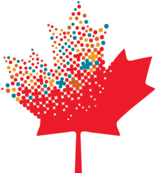
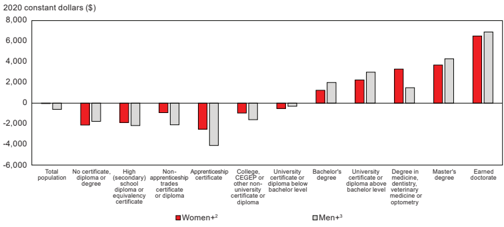
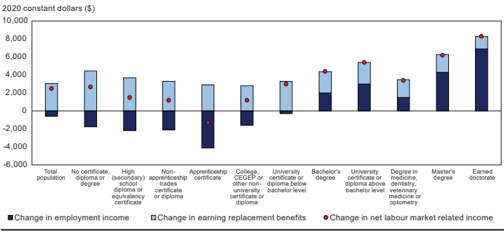
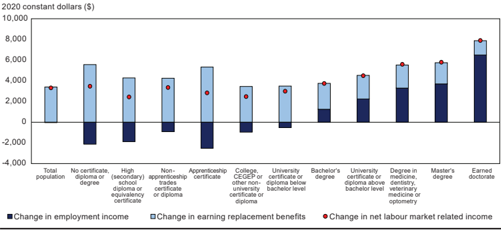

In [18]:
extracted_figures
# doc.pictures[0].image.uri._url.__str__()

In [19]:
# extracted_figures[0].data
extracted_texts

[Extracted(extracted_type=<ExtractedType.TEXT: 'text'>, page_no=1, path=None, coordinates=Coordinates(x1=37, y1=123, x2=188, y2=143), data='## Census in Brief', data_type='text'),
 Extracted(extracted_type=<ExtractedType.TEXT: 'text'>, page_no=1, path=None, coordinates=Coordinates(x1=37, y1=154, x2=370, y2=212), data='Changes in income across different levels of educational attainment during the first year of the COVID-19 pandemic', data_type='text'),
 Extracted(extracted_type=<ExtractedType.TEXT: 'text'>, page_no=1, path=None, coordinates=Coordinates(x1=36, y1=246, x2=217, y2=259), data='Census of Population, 2021', data_type='text'),
 Extracted(extracted_type=<ExtractedType.TEXT: 'text'>, page_no=1, path=None, coordinates=Coordinates(x1=36, y1=356, x2=172, y2=365), data='Release date: October 4, 2023', data_type='text'),
 Extracted(extracted_type=<ExtractedType.TEXT: 'text'>, page_no=2, path=None, coordinates=Coordinates(x1=37, y1=47, x2=219, y2=57), data='## How to obtain more infor

In [59]:
doc.texts[0].prov[0].bbox.to_top_left_origin(doc.pages[doc.texts[0].prov[0].page_no].size.height)


BoundingBox(l=72.024, t=89.92200000000003, r=390.039, b=114.39099999999996, coord_origin=<CoordOrigin.TOPLEFT: 'TOPLEFT'>)

In [29]:
# for item in doc.iterate_items():
#     print(item)
#     break
# doc.texts[10].__dict__
# doc.export_to_element_tree().split("\n")

serializer = MarkdownDocSerializer(doc=doc)

In [37]:
serializer.serialize(item=doc.tables[0]).text

'Table 1 Place of birth of the French-speaking population, by province or territory of residence, 2021\n\n|                                    | Born in their province or territory of residence   | Born in Quebec   | Born in another province or territory   | Born abroad   |\n|------------------------------------|----------------------------------------------------|------------------|-----------------------------------------|---------------|\n| Province or territory of residence |                                                    | percent          |                                         |               |\n| New Brunswick                      | 86.8                                               | 6.7              | 2.9                                     | 3.6           |\n| Quebec                             | 86.2                                               | 86.2             | 2.1                                     | 11.7          |\n| Manitoba                           | 74.4 

In [41]:
doc.texts[0]

SectionHeaderItem(self_ref='#/texts/0', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, meta=None, label=<DocItemLabel.SECTION_HEADER: 'section_header'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=36.043, t=669.534, r=187.138, b=649.145, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 15))], orig='Census in Brief', text='Census in Brief', formatting=None, hyperlink=None, level=1)